In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import tensorflow as tf
import time

from scipy.stats import gamma
from scipy.stats import lognorm

In [10]:
# Price for zero-coupon bond with stochastic interest rate under Vasicek's model
def ZC_Vasicek(F, r, kappa, theta, sigma, t, T):
    
    delta_T = T - t
    
    B = (1 - np.exp(-kappa * delta_T)) / kappa
    
    A = np.exp((theta - (sigma**2) / (2 * kappa**2)) * (B - delta_T) - (sigma**2 / (4 * kappa)) * B**2)
    
    bond_price = F * A * np.exp(-B * r)
    
    return bond_price

0.8725903270331504


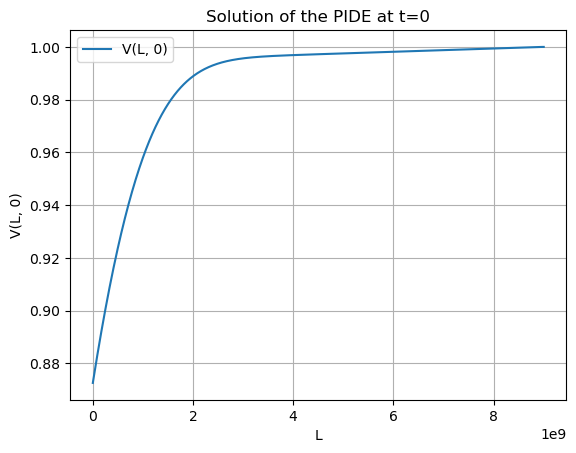

In [15]:
# Parameters
T = 2.0             # Final time
D = 9e9             # Default threshold
lam = 35       # Constant intensity

NT, NL, Nx = 200, 1000, 10000  # Time and space steps
dL = D / NL
dt = T / NT

L_grid = np.linspace(0, D, NL + 1)
t_grid = np.linspace(0, T, NT + 1)

# Lognormal distribution parameters
mu = 18.4
sig = 1


# === Initialize V(L, t) ===
V = np.zeros((NL + 1, NT + 1))
V[:, -1] = 0.0

#Jump size distribution
f = lambda l: lognorm.pdf(l, scale=np.exp(mu), s=sig)
F = lambda l: lognorm.cdf(l, scale=np.exp(mu), s=sig)

# === Backward time stepping ===
for n in reversed(range(NT)):
    t = t_grid[n]
    
    for i, L in enumerate(L_grid):

        if L > D:
            V[i, n] = 0.0
            continue

        # === Term 1 ===
        term1 = lam * V[i, n + 1]

        # === Term 2: jump leads to default ===
        safe_margin = D - L
        term2 = -lam * (1 - F(safe_margin))

        # Term 3: expected contribution from non-default jumps
        l_vals = np.linspace(0, safe_margin, Nx)
        dx = safe_margin / Nx
        V_interp = np.interp(L + l_vals, L_grid, V[:, n + 1], left=0.0, right=0.0)
        integrand = np.sum(V_interp * f(l_vals)) * dx
        term3 = -lam * integrand

        dVdt = term1 + term2 + term3
        V[i, n] = V[i, n+1] - dt * dVdt
        V[i, n] = np.clip(V[i, n], 0.0, 1.0)

print(V[0,0])

# Plot V(L, 0)
plt.plot(L_grid, V[:, 0], label='V(L, 0)')
plt.xlabel('L')
plt.ylabel('V(L, 0)')
plt.title('Solution of the PIDE at t=0')
plt.grid()
plt.legend()
plt.show()

In [25]:
def solve_pide(D, lam, NT, NL, Nx, mu, sig, T):
    dL = D / NL
    dT = T / NT

    L_grid = np.linspace(0, D, NL + 1)
    t_grid = np.linspace(0, T, NT + 1)

    # Initialize V(L, t)
    V = np.zeros((NL + 1, NT + 1))
    V[:, -1] = 0.0

    # Jump size distribution
    f = lambda l: lognorm.pdf(l, scale=np.exp(mu), s=sig)
    F = lambda l: lognorm.cdf(l, scale=np.exp(mu), s=sig)

    # Backward time stepping
    for n in reversed(range(NT)):
        for i, L in enumerate(L_grid):

            if L >= D:
                V[i, n] = 0.0
                continue

            # Term 1: continuation
            term1 = lam * V[i, n + 1]

            # Term 2: jump causes default
            safe_margin = D - L
            term2 = -lam * (1 - F(safe_margin))

            # Term 3: expected continuation value of non-default jumps
            l_vals = np.linspace(0, safe_margin, Nx)
            dx = safe_margin / Nx
            V_interp = np.interp(L + l_vals, L_grid, V[:, n + 1], left=0.0, right=0.0)
            integrand = np.sum(V_interp * f(l_vals)) * dx
            term3 = -lam * integrand

            dVdT = term1 + term2 + term3
            V[i, n] = V[i, n + 1] - dT * dVdT
            V[i, n] = np.clip(V[i, n], 0.0, 1.0)

    return V[0,0]


In [27]:
# Zero-coupon CAT bond pricing under IS
def CAT_ZC_PIDE(D, lam, T):
    return ZC_Vasicek(F, r, kappa, theta, sigma, t, T)*(1-solve_pide(D, lam, NT, NL, Nx, mu, sig, T))

In [29]:
# CAT bond with coupons pricing
def CAT_C_PIDE(D, lam, N, T):
    c_sum = 0
    dt = T/N

    for coupon_count in range (N):
        c_sum += ZC_Vasicek(F*c, r, kappa, theta, sigma, t, T=(coupon_count+1)*dt)*(1-solve_pide(D, lam, NT, NL, Nx, mu, sig, T=(coupon_count+1)*dt))
        
    c_sum = c_sum + ZC_Vasicek(F, r, kappa, theta, sigma, t, T)*(1-solve_pide(D, lam, NT, NL, Nx, mu, sig, T))
    return c_sum

In [31]:
# Parameter ranges
F = 1  # Fixed face value
t = 0     # Fixed initial time
mu = 18.4     # Fixed Lognormal scale
sig = 1       # Fixed Lognormal std
c=0.05
r=0.03
kappa=0.2
theta=0.03
sigma=0.02
NT=200 
NL=1000
Nx=10000

D=9e9
lam=35
N=0
T=1

num_runs = 1  # Number of iterations
results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_ZC_PIDE(D, lam, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 0.9448752780498627
Time taken for prediction: 55.199017 seconds


In [33]:
N=2
T=1

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 1.0413496380285234
Time taken for prediction: 167.296388 seconds


In [34]:
N=4
T=1

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 1.1396708046121624
Time taken for prediction: 283.688013 seconds


In [35]:
N=8
T=2

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 0.4354592786068726
Time taken for prediction: 512.260142 seconds


In [36]:
N=12
T=2

results = []  # Store function outputs

start_time = time.time()  # Start timing

for _ in range(num_runs):
    result = CAT_C_PIDE(D, lam, N, T)  # Run the function
    results.append(result)  # Store the result

end_time = time.time()  # End timing

# Compute statistics
total_time_PIDE = end_time - start_time  # Total execution time
prediction_PIDE = np.mean(results)  # Mean of the function outputs

# Print results
print("Prediction:", prediction_PIDE)
print(f"Time taken for prediction: {total_time_PIDE:.6f} seconds")

Prediction: 0.593188339465332
Time taken for prediction: 741.070946 seconds
